<a href="https://colab.research.google.com/github/opi-lab/optical-metrology-2021/blob/gh-pages/notebooks/calibracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de calibración 

Andrés Marrugo, PhD    
Universidad Tecnológica de Bolívar 

**Ejemplo.** Un sistema de medida de altura usando pulsos de luz. La tabla muestra los valores reales 
y los medidos (con error) cuando se incrementa la distancia y cuando se disminuye. Desarrolle la calibración y establezca el margen de error con un nivel de confianza del 99.7% para un valor medido de 4.32mm.

|   X ref(mm) |   Y medido (Inc.) |   Y medido (Dism.)  |
|-------------:|------------------:|--------------------:|
|            0 |             -1.12 |               -0.69 |
|            1 |              0.21 |                0.42 |
|            2 |              1.18 |                1.65 |
|            3 |              2.09 |                2.48 |
|            4 |              3.33 |                3.62 |
|            5 |              4.50 |                4.71 |
|            6 |              5.26 |                5.87 |
|            7 |              6.59 |                6.86 |
|            8 |              7.73 |                7.92 |
|            9 |              8.68 |                9.10 |
|           10 |              9.88 |               10.20 |

## Solucion

El ejercicio no lo indica, pero podríamos suponer que cada valor medido y (respuesta instrumental), viene de realizar varias mediciones para cada valor de entrada $X_{ref}$ y se calcula un promedio $\bar{y}$ y una varianza $S$. Como tal cada valor se reporta con [un margen de error y nivel de confianza](http://www.stat.wmich.edu/s216/book/node79.html "t-based Confidence Interval for the Mean") $(1-\alpha)100\%$: 

$$\bar{y}\pm t \left( \tfrac{S}{\sqrt{n}} \right)$$

donde $t$ es el valor crítico de la distribución $t_{n-1}$. Grafiquemos los datos y observemos su comportamiento.

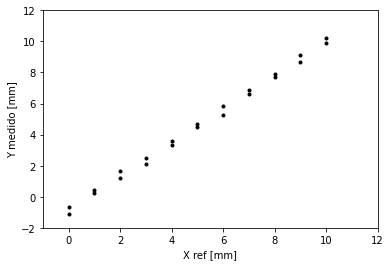

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns

# X referencia: se asume su incertidumbre muy baja
X = np.arange(0,11)
x = np.hstack([X,X])

# y
y_inc = np.array([-1.12, 0.21, 1.18, 2.09, 3.33, 4.5, 5.26, 6.59, 7.73, 8.68, 9.88])
y_dis = np.array([-0.69, 0.42, 1.65, 2.48, 3.62, 4.71, 5.87, 6.86, 7.92, 9.10, 10.20])
# y = np.mean([y_inc, y_dis], axis=0)
y = np.hstack([y_inc,y_dis])

plt.plot(X,y_inc,'.k')
plt.plot(X,y_dis,'.k')
plt.ylabel('Y medido [mm]')
plt.xlabel('X ref [mm]')
plt.axis([-1,12,-2,12])
plt.show()

Se observa que no hay mucha dispersión de los datos y la tendencia claramente es lineal. 
Ahora procedemos a realizar la calibración mediante regresión lineal no ponderada. Para $Y$ tomaremos 
las dos columnas. No analizaremos el error por histéresis en este momento.

In [2]:
# Numero de datos
n = len(x)

# polyfit computes the coefficients b1 and b0 of degree=1 via Least Squares
p, V = np.polyfit(x,y,1,cov=True)

b1 = p[0] # slope
b0 = p[1] # intercept

print('The coefficients are b1 = %2.4f and b0 = %2.4f' % (b1, b0))

The coefficients are b1 = 1.0839 and b0 = -0.8525


In [3]:
# Manual estimation

b1 = np.sum((x-x.mean())*y)/np.sum((x-x.mean())**2)

b0 = y.mean() - b1*x.mean()

print('the coefficients are b1 = %2.4f, and b0 = %2.4f' % (b1,b0))


S2yx = np.sum((y-(b1*x+b0))**2)/(n-2)
print('The residual standard deviation: %6.4f' % np.sqrt(S2yx))

S2b1 = S2yx/np.sum((x-x.mean())**2)
print('The standard deviation of b1: %6.4f' % np.sqrt(S2b1))

S2b0 = S2yx*(1/n+(x.mean()**2)/np.sum((x-x.mean())**2))

print('The standard deviation of b0: %6.4f' % np.sqrt(S2b0))

the coefficients are b1 = 1.0839, and b0 = -0.8525
The residual standard deviation: 0.2043
The standard deviation of b1: 0.0138
The standard deviation of b0: 0.0815


Recall that the residual standard deviation $S_{y/x}$ represents the dispersion of the residue against the model. It should be normal.

In [4]:
# Para reportar los parametros b1 y b0 con su respectivo margen de error 99.7% confianza
# n-2 grados de libertad porque se estimaron dos parametros 

t_alpha = stats.t.ppf(1-0.003/2,n-2)
print('Con un 99.7% de confianza los valores de b1 y b0:')
print('b1 = %2.4f ± %2.4f' % (b1, t_alpha*np.sqrt(S2b1)))
print('b0 = %2.4f ± %2.4f' % (b0, t_alpha*np.sqrt(S2b0)))

Con un 99.7% de confianza los valores de b1 y b0:
b1 = 1.0839 ± 0.0465
b0 = -0.8525 ± 0.2751


In [5]:
# Calculate real value with uncertainty based on measurement

y0m = 4.32 # valor medido en mm, respuesta instrumental

# usando regresion lineal para estimar valor verdadero
x0 = (y0m-b0)/b1
print('The estimated real value is: %6.4f' % x0)

# estimar la varianza de x0 estimado

S2x0 = S2yx/b1**2 * (1/2+1/n+(x0-x.mean())**2/(np.sum((x-x.mean())**2)))
print('Estimated x0 variance is: %2.4e' % S2x0)


# Assuming x0 approximately normal the limits of the (1-alpha)100% confidence interval
# for the true value of x0 corresponding to the response average y0m are
# x0m± = x0 ± t(1-alpha/2,n-2)Sx0
# alpha is 0.05 for 95% confidence
# n-2 degrees of freedom

t_alpha = stats.t.ppf(1-0.003/2,n-2)

print(stats.t.interval(1-0.003,n-2,loc=x0,scale=np.sqrt(S2x0)))


print('The x0 value with uncertainty 99.7 is: %4.4f ± %4.4f' % (x0, t_alpha*np.sqrt(S2x0)))
print('The x0 range is: (%4.4f, %4.4f)' % (x0-t_alpha*np.sqrt(S2x0), x0+t_alpha*np.sqrt(S2x0)))

print('The bias error is: %2.4f, and the random error is: ±%2.4f' % (x0-y0m,t_alpha*np.sqrt(S2x0)))

The estimated real value is: 4.7723
Estimated x0 variance is: 1.9384e-02
(4.302192224439571, 5.2423663832349945)
The x0 value with uncertainty 99.7 is: 4.7723 ± 0.4701
The x0 range is: (4.3022, 5.2424)
The bias error is: 0.4523, and the random error is: ±0.4701


Nótese que el error *bias* (sesgo) es relativamente alto (0.4523 mm) y esto se debe a que el modelo de la respuesta instrumental no pasa por (0,0). El intersecto es en -0.8525. Esto se puede corregir en la calibración y es normal que ocurra. Por otra parte, el error aleatorio con 99.7% de confianza es relativamente pequeño y tiene sentido, pues hay poca dispersión en los datos.